# Three Layer Framework for Trip Purpose Inference 
<hr> 

Trip purpose inference problem has not been thoroughly addressed in developing countries despite the fact that the applicability of a trip purpose inference model extremely depends on the land use context. 

Hence, this study attempted to ameliorate an accurate model (base model) based on taxi data collected for a selected area of a developing country and introduce a new model. 

The proposed model consists of three layers in which the first two layers align the model to the specified land use context. 

<b> Layer 1 </b> : Regular trip purpose identification 
    
<b> Layer 2 </b> : Identifying trips attracted to residential places 

<b> Layer 3 </b> : Bayesian purpose inference (base model)  

<b> Required Data </b> : Point of Intereset (POI) data, GPS (origin and destination) records of trips, Route network data.  

<b> Additional Data </b> : 

Temporal impact data for Bayesian purpose inference (base model) [Click Here] </br>

Opening times of the POIs [Click Here]

## Package Import 

In [2]:
# general packages 
import numpy as np 
import pandas as pd 
import geopandas as gpd 
from shapely.geometry import Point
import shapely.speedups 
shapely.speedups.enable()
import math 
from shapely.geometry import Polygon
from collections import Counter

In [3]:
# ML packages 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [4]:
# visualization packages
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# custom functions
from Functions import linear_distance, bayesian_inference, candidate_poi_selection, regularity, regularity_inference, residential

In [5]:
# remove the default='warns'
pd.options.mode.chained_assignment = None 

In [3]:
# autocompletion magic command 
%config Completer.use_jedi = False

## Data Import 

### Places (POI) data

In [23]:
places['purpose'].unique()

array(['recreational', 'personal', 'medical', 'shopping', 'dining',
       'education', 'home', 'transit'], dtype=object)

In [12]:
# Prepare the POI data 
places = pd.read_csv('POI_data.csv',index_col = 0)
places = places[['clean_name','lat','lng','type_1','no_of_ratings','avg_rating','purpose','Type']]

C:\Users\HP\anaconda3\envs\GEO_NEW\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [13]:
# places gpd creation 
geometry = [Point(xy) for xy in zip(places.lng, places.lat)]
placesgpd  = gpd.GeoDataFrame(places, crs="EPSG:4326", geometry=geometry)
placesgpd.crs = "EPSG:4326"

### Taxi trips 

In [15]:
# import trip data
taxitrips = pd.read_csv('Taxi_trip_data.csv', index_col = 0, parse_dates = [11,12,13])
taxitrips = taxitrips[['trip_id', 'passenger_id', 'pickup_lat', 'pickup_long', 'dropoff_lat', 'dropoff_long', 'actual_pickup_time','pickup_time','drop_time']]

# optimize the data types 
taxitrips['trip_id'] = taxitrips ['trip_id'].astype(np.int32)
taxitrips[['pickup_lat', 'pickup_long', 'dropoff_lat', 'dropoff_long']] = taxitrips[['pickup_lat', 'pickup_long', 'dropoff_lat', 'dropoff_long']].astype(np.float32)

### Route network

In [17]:
# importing and filtering out the roads within the colombo district 
slroads = gpd.read_file('Road network\\hotosm_lka_roads_lines.shp',crs = {'init': 'epsg:4326'})
sri_lanka = gpd.read_file('Land area\lka_admbnda_adm2_slsd_20200305.shp',crs = {'init': 'epsg:4326'})
colombo = sri_lanka[sri_lanka['ADM2_EN']=='Colombo']
colombo.reset_index(drop=True, inplace=True)
mask = slroads.within(colombo.loc[0,'geometry'])
colomboroads = slroads.loc[mask]

### Inputs for baysean model 

In [18]:
# for the baysean inference 
# huanggrid 
huanggrid = pd.read_csv('Additional data\HuangGrid.csv',index_col = 0, parse_dates = [0])
huanggrid.columns = huanggrid.columns.str.replace(' ', '')
huanggrid['Day'] = huanggrid['Day'].str.replace(' ', '')

# time df 
time_df = pd.read_csv('Additional data\POI_opening_times.csv',index_col=0)
time_df.columns = time_df.columns.str.replace(' ', '')

## Layer 1 : Regular trip purpose identification 

Imputation of the trip purpose of commuters who regularly travel between identical locations is considered in the first layer. Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is used to identify the spatial clusters of Pick-Up Points (PUP) and Drop Off Points (DOP) of passenger taxi trips and the defined time bins are utilized to add the temporal frames to select regular trips intended for a purpose. Two scenarios (1) round trips, and (2) onward trips are identified from this, and the purposes are imputed considering the selected time bins for selected purposes. 

### Identifying the regular passengers (commuters)

In [191]:
# filter out weekday trips 
taxitrips['day'] = taxitrips['drop_time'].dt.day_of_week
taxitrips_weekday = taxitrips[taxitrips['day'].isin([0,1,2,3,4])]

# select the passengers with trips more than the defined number. 
minimum_days = 2
regular_passengers = np.array(taxitrips_weekday.groupby('passenger_id').filter(lambda group: group['day'].count() > minimum_days )['passenger_id'])
regular_passengers = np.unique(regular_passengers)

In [192]:
len(regular_passengers)

7605

There could be passengers with substantially higher number of trips which might be an error of the passenger_id attribute itself. Hence, it is required to remove such passengers from the identified regular passengers. 

In [32]:
# check for any abnormal passengers 
abnormal = []
for passenger in regular_passengers:
    if taxitrips[taxitrips['passenger_id'] == passenger].shape[0] > 100:
        abnormal.append(passenger)
        
regular_passengers = np.delete(regular_passengers, np.where(regular_passengers == abnormal[0])[0][0])

In [103]:
regular_passengers.shape

(32784,)

### Inferring the regular trip purposes

In [222]:
minimum_days = 2
purpose_identified_regular_trips = pd.DataFrame(columns = taxitrips.columns)
passengers_without_clusters = []

# assign variable for counting (additional)
no_cluster = 0
time_bin_missed = 0 
od_pair_missed = 0
od_pair_time_bin_missed = 0
onward_indices_check = 0
poi_missing = 0 
onward_trip_count = 0 
round_trip_count = 0 

for passenger in regular_passengers:
    
    passenger_data = taxitrips_weekday[taxitrips_weekday['passenger_id'] == passenger].reset_index() # df reseted indices will be used throughout the analysis
    
    origin_labels, destination_labels = regularity.dbscan_clustering(passenger_data[['pickup_lat', 'pickup_long']], passenger_data[['dropoff_lat', 'dropoff_long']], min_trips = minimum_days)
    
    # terminate if there are no clusters (all the labels are -1)
    if destination_labels.sum()/destination_labels.shape[0] == -1:
        no_cluster  = no_cluster + 1
        continue 
    
    # time bin compatibility assessment  
    regular_purposes = regularity.time_check(passenger_data, destination_labels, minium_match = minimum_days, work1 = [6,10], work2 = [12,14], education = [6,10])
    regular_purposes_keys = list(regular_purposes.keys()) 
    regular_purposes_values = list(regular_purposes.values())      
    
    time_matched_clusters = [x for x in regular_purposes_values if x>=1] 

    # terminate the processessing if 1.) no clusters (0), 2. time bins doesnt match(), 3. user has two different locations(>1) for a single time bin   
    if len(time_matched_clusters) != 1: 
            time_bin_missed = time_bin_missed + 1
            continue 
    else:
        time_bin_purpose = time_matched_clusters[0]
                     
    # od pair compatibility assessment 
    matched_indices = regularity.od_pair_check(origin_labels, destination_labels, minimum_match = minimum_days)
    if len(matched_indices) == 0:
            od_pair_missed = od_pair_missed + 1 
            continue 
            
    # check whether the time bined cluster has a matched od pair
    matched_onward_cluster = regular_purposes_keys[regular_purposes_values.index(time_matched_clusters[0])]
    
    if matched_onward_cluster in list(matched_indices.keys()):
        onward_indices = matched_indices[regular_purposes_keys[regular_purposes_values.index(time_matched_clusters[0])]]
    
    else:
        od_pair_time_bin_missed = od_pair_time_bin_missed + 1
        continue 
    
    # check for the minimum regularity again 
    if len(onward_indices) < minimum_days:
        onward_indices_check = onward_indices_check + 1 
        continue 
        
    # variable selection for candiate poi selection 
    latitude = passenger_data.loc[onward_indices,'dropoff_lat'].mean()
    longitude = passenger_data.loc[onward_indices, 'dropoff_long'].mean()
    drop_time =  passenger_data.loc[onward_indices[0], 'drop_time'] # takes only one as its already on the bins 
        
    # candidate poi selection    
    candidate_pois = candidate_poi_selection(placesgpd, latitude , longitude , drop_time, time_df, walking_radius = 150)
                
    if candidate_pois.shape[0] == 0: 
        poi_missing  = poi_missing + 1 
    
    # purpose assignment    
    # check for round trips 
    if len(matched_indices) >= 2:
        round_trip, return_indices  = regularity_inference.return_trip_check(onward_indices, passenger_data, matched_indices)
        
        # Scenario 1 (Round trip)
        if round_trip == True:
            round_trip_count = round_trip_count + 1 
            passenger_data = regularity_inference.round_trip_purpose_inference(candidate_pois, onward_indices, return_indices, time_bin_purpose, passenger_data)
            
        # Scenario 2 (onward trip)
        else:
            passenger_data = regularity_inference.onward_trip_purpose_inference(candidate_pois, onward_indices, time_bin_purpose, passenger_data)
            onward_trip_count = onward_trip_count + 1 
            
    # Scenario 2 (onward trip)
    else:
        passenger_data = regularity_inference.onward_trip_purpose_inference(candidate_pois, onward_indices, time_bin_purpose, passenger_data)
        onward_trip_count = onward_trip_count + 1 
        
    passenger_data = passenger_data.set_index('index') # required with the appending 
        
    purpose_identified_regular_trips = purpose_identified_regular_trips.append(passenger_data)    

In [ ]:
# summary details 
no_cluster, time_bin_missed , od_pair_missed, od_pair_time_bin_missed, onward_indices_check ,poi_missing, round_trip_count, onward_trip_count 

In [ ]:
# total regular pasengers vs the regular passengers with purpose imputed trips 
len(regular_passengers), len(purpose_identified_regular_trips['passenger_id'].unique())

In [ ]:
# drop the null rows 

print(purpose_identified_regular_trips['Trip purpose'].isna().sum())

purpose_identified_regular_trips['Trip purpose'] = purpose_identified_regular_trips['Trip purpose'].fillna(value = 1)

print(purpose_identified_regular_trips['Trip purpose'].isna().sum())

In [ ]:
# view the total number of imputed trips from layer 1 
purpose_identified_regular_trips.shape

In [ ]:
# trip count for purposes 
purpose_identified_regular_trips['Trip purpose'].value_counts()

In [208]:
# convert the purpose numbers to names 
new_purposes = {1.0:'work',2.0:'education',0.0:'residential'}
purpose_identified_regular_trips['Trip purpose'].replace(new_purposes, inplace = True)

In [210]:
purpose_identified_regular_trips['Trip purpose'].replace({'educational':'education'}, inplace = True)

In [212]:
# save the file to feather. 
purpose_identified_regular_trips = purpose_identified_regular_trips.reset_index()
purpose_identified_regular_trips['actual_pickup_time'] = pd.to_datetime(purpose_identified_regular_trips['actual_pickup_time'])
purpose_identified_regular_trips['pickup_time'] = pd.to_datetime(purpose_identified_regular_trips['pickup_time'])
purpose_identified_regular_trips['drop_time'] = pd.to_datetime(purpose_identified_regular_trips['drop_time'])

purpose_identified_regular_trips.to_feather("Results\1st_layer_output.feather")

## Layer 2: Identifying trips attracted to residential places 

- Houses are not included in the POI dataset. Neglecting this assign incorrect purpose for trip attracted to residential places. 

- Developed method is based on three assumptions!  <br/>
    1. DOPs per day can’t be located as groups (clusters)/ daily <br/>
    2. DOPs  shouldn’t locate with a very close proximity to the main road  <br/>
    3. If the trips attracted away from main roads belongs to a POI, it should be within a very narrow distance i.e. 15m!

### 1. Filtering the grouped DOPs

According to the first assumption, the DBSCAN algorithm is used to identify the groups of taxi DOPs. Then those groups are removed and the only the outliers are kept.

Note : This analysis is done based on data for a single day. Because when dealing with data for a period of time, definetly there could be groups when the passengers are using the service to fulfill the mandatory activities 

### 2. Filtering DOPs closer to main roads

Before going to removal of drop off points near to the roads, we have to go calculate the distance that each drop off point has from the nearest main road. 

With that we can go for the clustering, just like before the number of is determined not only by referring the elbow, but also considering the maximum of the distances  get from the clusters. 

### 3. Filtering the trips attracted to POIs

If the trip had attracted to a normal place instead of a residential place, it is assumed that a POI must stay within a radius of 15m. (a simple rule). This is because in the residential areas in general, there is less difficulty to stop nearly to a place.  

### Imputing trips attracted to residential places 

In [22]:
taxitrips_after_regular_inference = taxitrips.loc[taxitrips.index.difference(purpose_identified_regular_trips.index)]

In [87]:
## identification of trips attracted to the residential places 

# removal of trips that has clustered DOPs. 
possible_home, taxi_data =   residential.clustered_trip_removal(taxitrips_after_regular_inference, allowable_dops = 2)

# removal of trips closer to the main roads 
possible_home =   residential.min_road_distance_measure(possible_home,colomboroads)

# distance based clustering 
possible_home_selected, possible_home_before_selection = residential.distance_based_trip_removal(possible_home, clusters = 15, n_clusters_toremove = 1)

# remove the pois with closer POIs
actual_home_selected = residential.poi_existance_removal(possible_home_selected, placesgpd, allowable_distance = 10)

In [179]:
# save the file to feather. 
actual_home_selected = actual_home_selected.reset_index()
actual_home_selected['actual_pickup_time'] = pd.to_datetime(actual_home_selected['actual_pickup_time'])
actual_home_selected['pickup_time'] = pd.to_datetime(actual_home_selected['pickup_time'])
actual_home_selected['drop_time'] = pd.to_datetime(actual_home_selected['drop_time'])

actual_home_selected.to_feather("Results\\2nd_layer_output.feather")

## Layer 3: Baysean purpose inference  

In [106]:
# select the required trips for which the purpose inference is required form baysean model  
taxitrips_to_baysean_inference = taxitrips_after_regular_inference.loc[taxitrips_after_regular_inference.index.difference(actual_home_selected.index)]

In [109]:
# array to collect the results 
trip_purposes = np.array([])

for row in taxitrips_to_baysean_inference.itertuples():
    
    # candidate poi selection 
    candidate_pois = candidate_poi_selection(placesgpd, row.dropoff_lat, row.dropoff_long, row.drop_time, time_df, walking_radius = 100)
    
    # baysean inference 
    Trip_purpose = baysean_inference(candidate_pois, row.dropoff_lat, row.dropoff_long, row.drop_time, huanggrid)
    
    # collect the results for an array 
    trip_purposes = np.append(trip_purposes, Trip_purpose)

# attach to the dataframe     
taxitrips_to_baysean_inference['Trip purpose'] = trip_purposes

In [118]:
# save the file to feather. 
taxitrips_to_baysean_inference = taxitrips_to_baysean_inference.reset_index()
taxitrips_to_baysean_inference['actual_pickup_time'] = pd.to_datetime(taxitrips_to_baysean_inference['actual_pickup_time'])
taxitrips_to_baysean_inference['pickup_time'] = pd.to_datetime(taxitrips_to_baysean_inference['pickup_time'])
taxitrips_to_baysean_inference['drop_time'] = pd.to_datetime(taxitrips_to_baysean_inference['drop_time'])

taxitrips_to_baysean_inference.to_feather("Results\\3rd_layer_output.feather")

## Merging the results of three layers

<div class="alert alert-block alert-warning">
<b> FINAL MERGING :</b> append the dataframes with trip purposes in all three levels
</div>

In [34]:
purpose_identified_regular_trips = pd.read_feather("1st_layer_output.feather")
actual_home_selected = pd.read_feather("2nd_layer_output.feather")
taxitrips_to_baysean_inference = pd.read_feather("3rd_layer_output.feather")

In [28]:
#column name mismatch solve 
actual_home_selected.rename(columns= {'trip_id2':'trip_id'}, inplace = True)
taxitrips_to_baysean_inference.rename(columns = {'index':'trip_id'}, inplace = True)

# regular trips columns
required_columns = ['trip_id','passenger_id', 'pickup_lat',
       'pickup_long', 'dropoff_lat', 'dropoff_long', 'actual_pickup_time',
       'pickup_time', 'drop_time',  'Trip purpose' ]

purpose_identified_regular_trips = purpose_identified_regular_trips[required_columns]
actual_home_selected = actual_home_selected[required_columns]
taxitrips_to_baysean_inference = taxitrips_to_baysean_inference[required_columns]

In [29]:
taxitrips_to_baysean_inference['Trip purpose'].replace({'home':'residential'}, inplace = True)

In [30]:
taxitrips_with_purpose = purpose_identified_regular_trips.append(actual_home_selected).append(taxitrips_to_baysean_inference)

<AxesSubplot:>

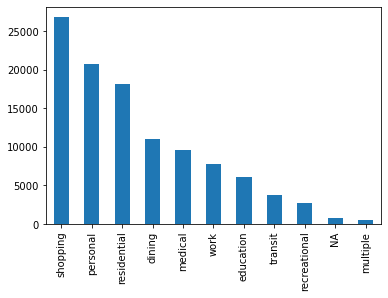

In [31]:
taxitrips_with_purpose['Trip purpose'].value_counts().plot(kind='bar')

In [33]:
# save the file to feather. 
taxitrips_with_purpose = taxitrips_with_purpose.reset_index(drop = True)
taxitrips_with_purpose['actual_pickup_time'] = pd.to_datetime(taxitrips_with_purpose['actual_pickup_time'])
taxitrips_with_purpose['pickup_time'] = pd.to_datetime(taxitrips_with_purpose['pickup_time'])
taxitrips_with_purpose['drop_time'] = pd.to_datetime(taxitrips_with_purpose['drop_time'])

taxitrips_with_purpose.to_feather(r"C:\Users\HP\Desktop\Projects\Trip purpose\\Three layer framework for purpose inference\\complete_output.feather")

In [6]:
taxitrips_with_purpose = pd.read_feather(r"C:\Users\HP\Desktop\Projects\Trip purpose\\Three layer framework for purpose inference\\complete_output.feather")

## EDA

visualizing the clustered and individual dops in residential trip identification 

In [ ]:
# stacked bar chart for daily distribution of trips 

# colors for purposes 
purpose_colors = {'education':'#916B01',
                  'work':'#4D949A', 
                  'residential': '#0F5512',
                  'medical': '#9B0000',
                  'recreational': '#009590' ,
                  'personal': '#70004B',
                  'shopping': '#878300',
                  'dining':'#C43B00', 
                  'multiple': '#000000',
                  'NA' : '#4D4D4D',
                  'transit' : '#CE4E4F'
                    }

x_values = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

purpose_groups = taxitrips_with_purpose.groupby('Trip purpose')
purposes = taxitrips_with_purpose['Trip purpose'].unique()

y_values_dict = {}

for purpose in purposes:
    
    purpose_df = purpose_groups.get_group(purpose).groupby('day').size().reset_index().set_index('day')
    y_values = [purpose_df.loc['Monday'].values[0], purpose_df.loc['Tuesday'].values[0], purpose_df.loc['Wednesday'].values[0], purpose_df.loc['Thursday'].values[0], purpose_df.loc['Friday'].values[0],  purpose_df.loc['Saturday'].values[0], purpose_df.loc['Sunday'].values[0]]
    y_values_dict[purpose] = y_values
    
# convert the dictionary keys to variables 
locals().update(y_values_dict)
    
# for purpose in purposes: 
bottom_raw = np.array([0,0,0,0,0,0,0])

for key in y_values_dict:
    
    ax.bar(x_values , y_values_dict[key], width, label = key, bottom = bottom_raw, color = purpose_colors[key])
    
    bottom_raw = bottom_raw + np.array(y_values_dict[key])

ax.set_ylabel('Count')
ax.legend(loc=0, bbox_to_anchor=(1, 1))
ax.set_xticklabels(x_values, rotation = 20)


plt.savefig(r"C:\Users\HP\Desktop\Projects\Trip purpose\\Three layer framework for purpose inference\\output_complete.jpg", dpi = 300, bbox_inches = 'tight')